In [1]:
import numpy as np 
import pandas as pd 
import json 

from geopy.geocoders import Nominatim 

import requests
from pandas.io.json import json_normalize 


import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

import folium 

print('Libraries imported.')

Libraries imported.


### Recover useful data from week 3 assigment (venues and clustering analysis obtained using FOURSQUARE)

We need: basic neighborhood, venues & clusters' information (previosly we've stored in csv format all relevant data). 

In [2]:
toronto_neighborhoods=pd.read_csv('toronto_neighborhoods.csv')

In [3]:
toronto_neighborhoods.head()

Postal Code      Borough                            Neighborhood
0         M1B  Scarborough                          Rouge, Malvern
1         M1C  Scarborough  Highland Creek, Rouge Hill, Port Union
2         M1E  Scarborough       Guildwood, Morningside, West Hill
3         M1G  Scarborough                                  Woburn
4         M1H  Scarborough                               Cedarbrae

We need to identify the category/activity of Toronto's venues searching for businesses related to our target (pets stores and vet clinics). This dataframe proceed from a FOURSQUARE query.

In [4]:
toronto_venues=pd.read_csv('toronto_venues.csv')

In [5]:
toronto_venues.head()

Neighborhood  Neighborhood Latitude  \
0                          Rouge, Malvern              43.806686   
1  Highland Creek, Rouge Hill, Port Union              43.784535   
2  Highland Creek, Rouge Hill, Port Union              43.784535   
3       Guildwood, Morningside, West Hill              43.763573   
4       Guildwood, Morningside, West Hill              43.763573   

   Neighborhood Longitude                           Venue  Venue Latitude  \
0              -79.194353                         Wendy’s       43.807448   
1              -79.160497           Royal Canadian Legion       43.782533   
2              -79.160497  Scarborough Historical Society       43.788755   
3              -79.188711               G & G Electronics       43.765309   
4              -79.188711                      Marina Spa       43.766000   

   Venue Longitude        Venue Category  
0       -79.199056  Fast Food Restaurant  
1       -79.163085                   Bar  
2       -79.162438        History Museum  
3       -79.191537     Electronics Store  
4       -79.191000                   Spa

The information about clusters is stored in the following csv file:

In [6]:
toronto_clusters=pd.read_csv('toronto_clusters.csv')

In [7]:
toronto_clusters['Cluster Labels'] = toronto_clusters['Cluster Labels'].astype('int64')
toronto_clusters['Cluster Labels'] = pd.Categorical(toronto_clusters['Cluster Labels'])

In [8]:
toronto_clusters.head()

Postal Code      Borough                            Neighborhood   Latitude  \
0         M1B  Scarborough                          Rouge, Malvern  43.806686   
1         M1C  Scarborough  Highland Creek, Rouge Hill, Port Union  43.784535   
2         M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3         M1G  Scarborough                                  Woburn  43.770992   
4         M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0 -79.194353              1  Fast Food Restaurant         Women's Store   
1 -79.160497              1                   Bar         Women's Store   
2 -79.188711              1    Mexican Restaurant        Breakfast Spot   
3 -79.216917              1           Coffee Shop          Soccer Field   
4 -79.239476              1           Gas Station       Thai Restaurant   

  3rd Most Common Venue 4th Most Common Venue        5th Most Common Venue  \
0         Deli / Bodega     Electronics Store  Eastern European Restaurant   
1         Deli / Bodega     Electronics Store  Eastern European Restaurant   
2                  Bank        Medical Center                 Intersection   
3     Korean Restaurant               Dog Run                 Dessert Shop   
4   Fried Chicken Joint                  Bank           Athletics & Sports   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0   Dumpling Restaurant             Drugstore            Donut Shop   
1   Dumpling Restaurant             Drugstore            Donut Shop   
2     Electronics Store   Rental Car Location                   Spa   
3    Dim Sum Restaurant                 Diner        Discount Store   
4  Caribbean Restaurant                Bakery      Hakka Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0      Doner Restaurant                Dog Run  
1      Doner Restaurant                Dog Run  
2      Doner Restaurant                Dog Run  
3   Distribution Center             Donut Shop  
4      Doner Restaurant                Dog Run

We only need some columns (postal code, neighborhood,latitude,longitude and cluster labels):

In [10]:
toronto_clusters=toronto_clusters.drop(['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue',
                      '5th Most Common Venue','6th Most Common Venue','7th Most Common Venue','8th Most Common Venue',
                      '9th Most Common Venue','10th Most Common Venue'],axis=1)
toronto_clusters.head()

Postal Code      Borough                            Neighborhood   Latitude  \
0         M1B  Scarborough                          Rouge, Malvern  43.806686   
1         M1C  Scarborough  Highland Creek, Rouge Hill, Port Union  43.784535   
2         M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3         M1G  Scarborough                                  Woburn  43.770992   
4         M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude Cluster Labels  
0 -79.194353              1  
1 -79.160497              1  
2 -79.188711              1  
3 -79.216917              1  
4 -79.239476              1

### We obtain data about vet clinics and pet shops in Toronto & surrondings (name and coordinates) obtained from FOURSQUARE:

First, we are going to search for venues that own to our sector (pet care and shops). Checking the 'Venue Category' column from toronto_venues dataframe we can identify related terms to our seek:

In [11]:
toronto_venues['Venue Category'].unique()


array(['Fast Food Restaurant', 'Bar', 'History Museum',
       'Electronics Store', 'Spa', 'Mexican Restaurant',
       'Rental Car Location', 'Bank', 'Moving Target', 'Medical Center',
       'Intersection', 'Breakfast Spot', 'Coffee Shop',
       'Korean Restaurant', 'Hakka Restaurant', 'Caribbean Restaurant',
       'Thai Restaurant', 'Athletics & Sports', 'Gas Station', 'Bakery',
       'Fried Chicken Joint', 'Playground', 'Grocery Store',
       'Department Store', 'Convenience Store', 'Chinese Restaurant',
       'Hobby Shop', 'Ice Cream Shop', 'Bus Line', 'Metro Station',
       'Park', 'Soccer Field', 'Motel', 'American Restaurant', 'Café',
       'General Entertainment', 'Skating Rink', 'College Stadium',
       'Indian Restaurant', 'Vietnamese Restaurant', 'Pet Store',
       'Light Rail Station', 'Smoke Shop', 'Middle Eastern Restaurant',
       'Latin American Restaurant', 'Lounge', 'Clothing Store',
       'Italian Restaurant', 'Noodle House', 'Shopping Mall',
       'Pizz

In the Foursquare location data we can only find 'Pet stores' venues. There isn't vet clinics and similar (for instance, animal clinics), so we have to use other kinds of sources to complete the data we need.

In [12]:
df_pet_stores=toronto_venues[toronto_venues['Venue Category'].str.contains('Pet')]
df_pet_stores.head()

Neighborhood  Neighborhood Latitude  \
48   Dorset Park, Scarborough Town Centre, Wexford ...              43.757410   
180                                   Willowdale South              43.770120   
288                    Woodbine Gardens, Parkview Hill              43.706397   
317                                            Leaside              43.709060   
416                     The Beaches West, India Bazaar              43.668999   

     Neighborhood Longitude                     Venue  Venue Latitude  \
48               -79.273304  Big Al's Pet Supercentre       43.759279   
180              -79.408493                  PetSmart       43.769139   
288              -79.309937   East York Animal Clinic       43.705921   
317              -79.363452                  PetSmart       43.712682   
416              -79.315572                  Pet Valu       43.666979   

     Venue Longitude Venue Category  
48        -79.278325      Pet Store  
180       -79.412522      Pet Store  
288       -79.312196      Pet Store  
317       -79.362636      Pet Store  
416       -79.314665      Pet Store

In [13]:
df_pet_stores.describe()

Neighborhood Latitude  Neighborhood Longitude  Venue Latitude  \
count              10.000000               10.000000       10.000000   
mean               43.691525              -79.372862       43.691463   
std                 0.052959                0.067758        0.053799   
min                43.605647              -79.501321       43.602431   
25%                43.661636              -79.416935       43.661722   
50%                43.687698              -79.365564       43.686450   
75%                43.727227              -79.321909       43.728682   
max                43.770120              -79.273304       43.769139   

       Venue Longitude  
count        10.000000  
mean        -79.373475  
std           0.066337  
min         -79.498653  
25%         -79.417659  
50%         -79.365548  
75%         -79.321273  
max         -79.278325

Although pet stores isn't our core activity (we are more interested in vet clinics sector) we are going to search for new pet stores in the surroundings of Toronto (Mississauga, Brampton, Vaughan, Markham, Ajax and Pickering) focusing on our Foursquare's seeking in these places (especially in the areas closer to the Toronto's limits). First, we define a list with Toronto's neighbourhoods situated in the limits:

In [14]:
surroundings=['M8W','M9C','M9W','M9L','M3N','M3J','M2R','M2M','M2H','M1W','M1V','M1X','M1B','M1C','M1E']

In [15]:
toronto_surroundings=toronto_clusters.loc[toronto_clusters['Postal Code'].isin(surroundings)]
toronto_surroundings=toronto_surroundings.reset_index()
toronto_surroundings.head()


index Postal Code      Borough  \
0      0         M1B  Scarborough   
1      1         M1C  Scarborough   
2      2         M1E  Scarborough   
3     14         M1V  Scarborough   
4     15         M1W  Scarborough   

                                        Neighborhood   Latitude  Longitude  \
0                                     Rouge, Malvern  43.806686 -79.194353   
1             Highland Creek, Rouge Hill, Port Union  43.784535 -79.160497   
2                  Guildwood, Morningside, West Hill  43.763573 -79.188711   
3  Agincourt North, L'Amoreaux East, Milliken, St...  43.815252 -79.284577   
4                                    L'Amoreaux West  43.799525 -79.318389   

  Cluster Labels  
0              1  
1              1  
2              1  
3              2  
4              1

We are going to use FOURSQUARE to searching pet stores in a radius (1000 m) from the limit of Toronto.

In [16]:
#Foursquare credentials:
with open(r'foursquarecredentials.json') as cred:
    credentials=json.load(cred)
CLIENT_ID=credentials['CLIENT_ID']
CLIENT_SECRET=credentials['CLIENT_SECRET']
VERSION=credentials['VERSION']
LIMIT=credentials['LIMIT']

In [17]:
def getCategoryVenues(names, latitudes, longitudes, search_query='Pet Store',radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng, 
            VERSION, 
            search_query, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]
        print(results)
        
    

In [18]:
surroundings__pet_stores = getCategoryVenues(names=toronto_surroundings['Neighborhood'],
                                   latitudes=toronto_surroundings['Latitude'],
                                   longitudes=toronto_surroundings['Longitude'])

Rouge, Malvern
{}
Highland Creek, Rouge Hill, Port Union
{}
Guildwood, Morningside, West Hill
{}
Agincourt North, L'Amoreaux East, Milliken, Steeles East
{}
L'Amoreaux West
{}
Hillcrest Village
{}
Willowdale West
{}
Northwood Park, York University
{}
Downsview Northwest
{}
Alderwood, Long Branch
{}
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
{}
Humber Summit
{}
Northwest
{}


According to our seek in FOURSQUARE in a radius of 1000 m from the limits of Toronto there isn't pet stores, so finally our pet_stores dataframe is the following:

In [19]:

df_pet_stores=df_pet_stores.rename(columns={'Venue':'Name','Venue Latitude':'Latitude','Venue Longitude':'Longitude'})
df_pet_stores=df_pet_stores.reset_index()
df_pet_stores=df_pet_stores.drop(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue Category','index'],axis=1)
df_pet_stores.head()

Name   Latitude  Longitude
0  Big Al's Pet Supercentre  43.759279 -79.278325
1                  PetSmart  43.769139 -79.412522
2   East York Animal Clinic  43.705921 -79.312196
3                  PetSmart  43.712682 -79.362636
4                  Pet Valu  43.666979 -79.314665

Now we are going to complete the Foursquare information related to vet clinics because according to our business approach it's our core business (pet stores are a secondary activity) and besides the number of existing clinics obtained from FOURSQUARE it's too low. To get this, we've used two kinds of sources: 1) For Toronto is available a list of vet clinics from Toronto Open Data Service. 2) For the surroundings (Mississauga, Brampton, Vaughan, Markham, Ajax and Pickering) we've used Google Earth service downloading a .kml file which contains coordinates and the name of vet clinics.

Source: https://www.toronto.ca/community-people/animals-pets/pet-licensing/bluepaw-partners/vets-hospitals/

In [20]:
#Using BeatifulSoup we can extract code information from web table:

import urllib.request, urllib.parse,urllib.error
from bs4 import BeautifulSoup
html=urllib.request.urlopen('https://www.toronto.ca/community-people/animals-pets/pet-licensing/bluepaw-partners/vets-hospitals/')

soup = BeautifulSoup(html,'html.parser')
table=soup.find_all('tbody')
     
print(table)

[<tbody>
<tr data-lat="43.6552217" data-lng="-79.35861190000003">
<td>Bay Cat and Dog Hospital</td>
<td><ul>
<li>20 per cent off first exam with free nail trim</li>
<li>10 per cent off booked dentals</li>
<li>10 per cent off pet toys</li>
</ul>
<p><strong>Address:</strong> 525 King Street East<br/>
<strong>Email:</strong> <a href="mailto:baycat-doghospital@hotmail.com">baycat-doghospital@hotmail.com</a><br/>
<strong>Cat hospital website:</strong> <a href="http://www.baycathospital.com/" rel="noopener" target="_blank">www.baycathospital.com</a><br/>
<strong>Dog hospital website:</strong> <a href="http://www.baydoghospital.com/" rel="noopener" target="_blank">www.baydoghospital.com</a></p>
</td>
</tr>
<tr data-lat="43.33892729999999" data-lng="-79.78532059999998">
<td>Bay Cities Animal Hospital (VCA Canada Hospital) </td>
<td><p>Free First General Practice wellness exam for dogs or cats, and up to $250 in complimentary care for the following conditions during your first visit to a VCA Ca

In [21]:
#From table we extract information about names of vet clinics:
import re
names=[]
for line in table:
    names.append(re.findall('(?<=<td>)(.*?)(?=</td>)',str(line)))

names=names[0]
print(names)


['Bay Cat and Dog Hospital', 'Bay Cities Animal Hospital (VCA Canada Hospital) ', 'Birchmount Animal Hospital (VCA Canada Hospital)', 'Bridletowne Warden Animal Hospital', 'Cachet Village Animal Hospital (VCA Hospital) ', 'Credit Valley Animal Hospital (VCA Canada Hospital)', 'Dundas West Animal Hospital', 'Guildcrest Cat Hospital', 'Islington Village Animal Hospital', 'Kingston Road Animal Hospital', 'Lakeshore Animal Hospital (VCA Canada Hospital) ', 'Lawrence Veterinary Clinic (VCA Hospital) ', 'Longbranch Animal Clinic', 'MacKay Animal Hospital (VCA Canada Hospital)', 'Metro Animal Hospital', 'Morningside Animal Hospital (VCA Canada Hospital)', 'Mt. Pleasant-Davisville Animal Hospital (VCA Canada Hospital) ', 'Queen West Animal Hospital', 'Riverdale Animal Hospital', 'Roncy Village Vet Clinic', 'Rosedale Animal Hospital (VCA Canada Hospital) ', 'Rouge Valley Veterinary Hospital', 'Secord Animal Hospital (VCA Canada Hospital) ', 'South Etobicoke Animal Hospital', 'St. Clair East Ani

In [22]:
#Too, we can get the coordinates from the web:
latitude=[]
longitude=[]
for line in table:
    long=re.findall('(?<=data-lng=")(.*?)(?=")',str(line))
    lat=re.findall('(?<=data-lat=")(.*?)(?=")',str(line))
    longitude.append(long)
    latitude.append(lat)       
latitude=latitude[0]
longitude=longitude[0]

print(longitude,latitude)        


['-79.35861190000003', '-79.78532059999998', '-79.29011489999999', '-79.30896389999998', '-79.3738907', '-79.73651960000001', '-79.45029360000001', '-79.2494668', '-79.53914209999999', '-79.28469610000002', '-79.56188329999998', '-79.42908560000001', '-79.52961829999998', '-78.93693289999999', '-79.29976850000003', '-79.18512809999999', '-79.38950790000001', '-79.41301099999998', '-79.33903989999999', '-79.44868150000002', '-79.39250659999999', '-79.19850359999998', '-79.40314769999998', '-79.50317009999998', '-79.30296120000003', '-79.45281090000003', '-79.423137', '-79.36227780000002'] ['43.6552217', '43.33892729999999', '43.76167840000001', '43.7810853', '43.8860006', '43.59852799999999', '43.6532565', '43.7097632', '43.64122330000001', '43.6806569', '43.57280699999999', '43.7194134', '43.5951932', '43.880896', '43.68884180000001', '43.7731419', '43.70744819999999', '43.64527229999999', '43.6798214', '43.6457019', '43.6837249', '43.80119370000001', '43.729639', '43.62606470000001', 

Now, we are import data from .kml files using Geopandas and Fiona:

In [23]:

import geopandas as gpd
import fiona

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

surroundings=['pickering.kml','vaughan.kml','mississauga.kml','brampton.kml','markham.kml','ajax.kml']

for surrounding in surroundings:

    file = gpd.read_file(surrounding, driver='KML')

    for files in range(0,len(file)):
        name_aux=file.loc[files,'Name']
        coord_aux=file.loc[files,'geometry']
        latitude_aux=coord_aux.y
        longitude_aux=coord_aux.x
        names.append(name_aux)
        latitude.append(latitude_aux)
        longitude.append(longitude_aux)    
    
  

In [24]:
#We define a dataframe with clinics data:

df_clinics = pd.DataFrame(list(zip(names, longitude,latitude)), 
               columns =['Name', 'Longitude','Latitude'])
   
df_clinics.head()


Name           Longitude  \
0                           Bay Cat and Dog Hospital  -79.35861190000003   
1  Bay Cities Animal Hospital (VCA Canada Hospital)   -79.78532059999998   
2   Birchmount Animal Hospital (VCA Canada Hospital)  -79.29011489999999   
3                 Bridletowne Warden Animal Hospital  -79.30896389999998   
4     Cachet Village Animal Hospital (VCA Hospital)          -79.3738907   

            Latitude  
0         43.6552217  
1  43.33892729999999  
2  43.76167840000001  
3         43.7810853  
4         43.8860006

In [25]:
df_clinics.describe(include='all')

Name  Longitude  \
count                                                  88  88.000000   
unique                                                 77  77.000000   
top     Vaughan - Richmond Hill Veterinary Emergency C... -79.301456   
freq                                                    2   2.000000   

         Latitude  
count   88.000000  
unique  77.000000  
top     43.878166  
freq     2.000000

Checking the 'describe' output we observe that some values are duplicated (it's possible because we've combined several sources of data). So, we are going to eliminate duplicated values:

In [26]:
df_clinics.drop_duplicates(keep=False,inplace=True) 
df_clinics=df_clinics.reset_index()

In [27]:
df_clinics.describe(include='all')

index                      Name           Longitude   Latitude
count   66.000000                        66                  66  66.000000
unique        NaN                        66                  66  66.000000
top           NaN  Longbranch Animal Clinic  -79.42908560000001  43.841771
freq          NaN                         1                   1   1.000000
mean    32.863636                       NaN                 NaN        NaN
std     19.638178                       NaN                 NaN        NaN
min      0.000000                       NaN                 NaN        NaN
25%     16.250000                       NaN                 NaN        NaN
50%     32.500000                       NaN                 NaN        NaN
75%     49.750000                       NaN                 NaN        NaN
max     67.000000                       NaN                 NaN        NaN

Using Folium library we can check the location of the existing vet clinics:

In [28]:
toronto_latitude=43.6534817
toronto_longitude=-79.3839347

map_toronto_vet_clinics = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=11)

# Map markers
for lat, lng, label in zip(df_clinics['Latitude'], df_clinics['Longitude'], df_clinics['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_vet_clinics)  
    
map_toronto_vet_clinics

### Another interesting dataset we can use: Licensed Dogs and Cats Reports in Toronto (2016)

Source: https://open.toronto.ca/dataset/licensed-dogs-and-cats-reports/

In [30]:
df2=pd.read_excel('https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/dc91b1db-dff7-4dc2-88d1-6031faf5f941',
                  header=2)

In [31]:
#This dataset uses postal codes as neighborhoods' identifier (named FSA): 
df2.head()

FSA  CAT  DOG  Total
0  M1B  285  627    912
1  M1C  297  775   1072
2  M1E  467  963   1430
3  M1G  220  385    605
4  M1H  155  309    464

In [32]:
df2.describe()

CAT           DOG         Total
count     98.000000     98.000000     98.000000
mean     499.897959   1152.224490   1652.122449
std     2453.741231   5653.381921   8106.527059
min        6.000000      0.000000      6.000000
25%      140.250000    329.000000    500.500000
50%      238.000000    557.500000    803.500000
75%      356.000000    810.750000   1208.250000
max    24495.000000  56459.000000  80954.000000

This information should be used comparing with neighbourhoods' population (we are going to estimate the number of pets/number of inhabitants ratios later).

### Population in neighborhoods data (2016)

Source:https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/comprehensive.cfm

In [33]:
df3=pd.read_csv('https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Tables/CompFile.cfm?Lang=Eng&T=1201&OFT=FULLCSV')

In [34]:

df3.head()

Geographic code Geographic name      Province or territory  \
0              01          Canada                        NaN   
1             A0A             A0A  Newfoundland and Labrador   
2             A0B             A0B  Newfoundland and Labrador   
3             A0C             A0C  Newfoundland and Labrador   
4             A0E             A0E  Newfoundland and Labrador   

  Incompletely enumerated Indian reserves and Indian settlements, 2016  \
0                                                  T                     
1                                                NaN                     
2                                                NaN                     
3                                                NaN                     
4                                                NaN                     

   Population, 2016  Total private dwellings, 2016  \
0        35151728.0                     15412443.0   
1           46587.0                        26155.0   
2           19792.0                        13658.0   
3           12587.0                         8010.0   
4           22294.0                        12293.0   

   Private dwellings occupied by usual residents, 2016  
0                                         14072079.0    
1                                            19426.0    
2                                             8792.0    
3                                             5606.0    
4                                             9603.0

In [35]:
df3.describe(include='all')

Geographic code Geographic name Province or territory  \
count             1648            1643                  1641   
unique            1648            1643                    12   
top                R3E             R3E               Ontario   
freq                 1               1                   523   
mean               NaN             NaN                   NaN   
std                NaN             NaN                   NaN   
min                NaN             NaN                   NaN   
25%                NaN             NaN                   NaN   
50%                NaN             NaN                   NaN   
75%                NaN             NaN                   NaN   
max                NaN             NaN                   NaN   

       Incompletely enumerated Indian reserves and Indian settlements, 2016  \
count                                                   1                     
unique                                                  1                     
top                                                     T                     
freq                                                    1                     
mean                                                  NaN                     
std                                                   NaN                     
min                                                   NaN                     
25%                                                   NaN                     
50%                                                   NaN                     
75%                                                   NaN                     
max                                                   NaN                     

        Population, 2016  Total private dwellings, 2016  \
count       1.642000e+03                   1.642000e+03   
unique               NaN                            NaN   
top                  NaN                            NaN   
freq                 NaN                            NaN   
mean        4.281575e+04                   1.877277e+04   
std         8.671192e+05                   3.801885e+05   
min         0.000000e+00                   0.000000e+00   
25%         9.258250e+03                   4.127000e+03   
50%         1.806650e+04                   8.106500e+03   
75%         2.932950e+04                   1.315925e+04   
max         3.515173e+07                   1.541244e+07   

        Private dwellings occupied by usual residents, 2016  
count                                        1.642000e+03    
unique                                                NaN    
top                                                   NaN    
freq                                                  NaN    
mean                                         1.714017e+04    
std                                          3.471212e+05    
min                                          0.000000e+00    
25%                                          3.758000e+03    
50%                                          7.396000e+03    
75%                                          1.225900e+04    
max                                          1.407208e+07

In [36]:
#Drop all column we don't need:

df3=df3.drop(['Geographic name','Province or territory','Incompletely enumerated Indian reserves and Indian settlements, 2016',
            'Total private dwellings, 2016','Private dwellings occupied by usual residents, 2016'],axis=1)
df3.head()

Geographic code  Population, 2016
0              01        35151728.0
1             A0A           46587.0
2             A0B           19792.0
3             A0C           12587.0
4             A0E           22294.0

Finally, we associate neighborhoods with their population based on df3 dataset:

In [37]:
df_population=toronto_neighborhoods.merge(df3,how='inner',left_on='Postal Code', right_on='Geographic code')
df_population.head()

Postal Code      Borough                            Neighborhood  \
0         M1B  Scarborough                          Rouge, Malvern   
1         M1C  Scarborough  Highland Creek, Rouge Hill, Port Union   
2         M1E  Scarborough       Guildwood, Morningside, West Hill   
3         M1G  Scarborough                                  Woburn   
4         M1H  Scarborough                               Cedarbrae   

  Geographic code  Population, 2016  
0             M1B           66108.0  
1             M1C           35626.0  
2             M1E           46943.0  
3             M1G           29690.0  
4             M1H           24383.0

In [38]:
df_population=df_population.drop(['Borough','Geographic code'],axis=1)
df_population.head()

Postal Code                            Neighborhood  Population, 2016
0         M1B                          Rouge, Malvern           66108.0
1         M1C  Highland Creek, Rouge Hill, Port Union           35626.0
2         M1E       Guildwood, Morningside, West Hill           46943.0
3         M1G                                  Woburn           29690.0
4         M1H                               Cedarbrae           24383.0

### Now we can study all data. First, we'll obtain licensed pets ratio (number of dogs/cats per each 1000 inhabitants):

In [40]:
#First,we merge population and pets licensed tables:
df_pets_ratio=df_population.merge(df2,how='inner',left_on='Postal Code', right_on='FSA')
df_pets_ratio=df_pets_ratio.drop(['FSA'],axis=1)
df_pets_ratio.head()

Postal Code                            Neighborhood  Population, 2016  CAT  \
0         M1B                          Rouge, Malvern           66108.0  285   
1         M1C  Highland Creek, Rouge Hill, Port Union           35626.0  297   
2         M1E       Guildwood, Morningside, West Hill           46943.0  467   
3         M1G                                  Woburn           29690.0  220   
4         M1H                               Cedarbrae           24383.0  155   

   DOG  Total  
0  627    912  
1  775   1072  
2  963   1430  
3  385    605  
4  309    464

In [41]:
#Now, we can estimate pets' ratios using data stored in the columns:

df_pets_ratio['dogs_ratio']=df_pets_ratio['DOG']*1000/df_pets_ratio['Population, 2016']
df_pets_ratio['cats_ratio']=df_pets_ratio['CAT']*1000/df_pets_ratio['Population, 2016']
df_pets_ratio['pets_ratio']=df_pets_ratio['Total']*1000/df_pets_ratio['Population, 2016']
df_pets_ratio=df_pets_ratio.dropna()
df_pets_ratio.head()

Postal Code                            Neighborhood  Population, 2016  CAT  \
0         M1B                          Rouge, Malvern           66108.0  285   
1         M1C  Highland Creek, Rouge Hill, Port Union           35626.0  297   
2         M1E       Guildwood, Morningside, West Hill           46943.0  467   
3         M1G                                  Woburn           29690.0  220   
4         M1H                               Cedarbrae           24383.0  155   

   DOG  Total  dogs_ratio  cats_ratio  pets_ratio  
0  627    912    9.484480    4.311127   13.795607  
1  775   1072   21.753775    8.336608   30.090383  
2  963   1430   20.514241    9.948235   30.462476  
3  385    605   12.967329    7.409902   20.377231  
4  309    464   12.672764    6.356888   19.029652

In [42]:
df_pets_ratio.describe(include='all')

Postal Code Neighborhood  Population, 2016         CAT          DOG  \
count           97           97         97.000000   97.000000    97.000000   
unique          97           97               NaN         NaN          NaN   
top            M9R   Davisville               NaN         NaN          NaN   
freq             1            1               NaN         NaN          NaN   
mean           NaN          NaN      28166.072165  252.525773   582.051546   
std            NaN          NaN      14230.972172  155.503958   319.776757   
min            NaN          NaN         15.000000    6.000000     0.000000   
25%            NaN          NaN      18241.000000  138.000000   322.000000   
50%            NaN          NaN      25473.000000  237.000000   556.000000   
75%            NaN          NaN      37769.000000  353.000000   807.000000   
max            NaN          NaN      75897.000000  676.000000  1315.000000   

             Total  dogs_ratio  cats_ratio  pets_ratio  
count     97.00000   97.000000   97.000000   97.000000  
unique         NaN         NaN         NaN         NaN  
top            NaN         NaN         NaN         NaN  
freq           NaN         NaN         NaN         NaN  
mean     834.57732   22.187548   13.136983   35.324531  
std      465.58773   11.143767   39.894728   40.056114  
min        6.00000    0.000000    2.318341    6.399837  
25%      495.00000   12.967329    6.281160   19.342028  
50%      798.00000   20.063015    8.196721   28.847757  
75%     1197.00000   30.617737   11.503099   42.866410  
max     1864.00000   47.157004  400.000000  400.000000

Too, we can integrate this information in the cluster table:

In [43]:
df_pets_ratio_clusters=toronto_clusters.merge(df_pets_ratio,how='inner',left_on='Postal Code', right_on='Postal Code')
df_pets_ratio_clusters.head()

Postal Code      Borough                          Neighborhood_x   Latitude  \
0         M1B  Scarborough                          Rouge, Malvern  43.806686   
1         M1C  Scarborough  Highland Creek, Rouge Hill, Port Union  43.784535   
2         M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3         M1G  Scarborough                                  Woburn  43.770992   
4         M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude Cluster Labels                          Neighborhood_y  \
0 -79.194353              1                          Rouge, Malvern   
1 -79.160497              1  Highland Creek, Rouge Hill, Port Union   
2 -79.188711              1       Guildwood, Morningside, West Hill   
3 -79.216917              1                                  Woburn   
4 -79.239476              1                               Cedarbrae   

   Population, 2016  CAT  DOG  Total  dogs_ratio  cats_ratio  pets_ratio  
0           66108.0  285  627    912    9.484480    4.311127   13.795607  
1           35626.0  297  775   1072   21.753775    8.336608   30.090383  
2           46943.0  467  963   1430   20.514241    9.948235   30.462476  
3           29690.0  220  385    605   12.967329    7.409902   20.377231  
4           24383.0  155  309    464   12.672764    6.356888   19.029652

In [44]:
df_pets_ratio_clusters_sorted=df_pets_ratio_clusters.sort_values(by=['pets_ratio'], ascending=False)
df_pets_ratio_clusters_sorted=df_pets_ratio_clusters_sorted.drop(['Neighborhood_y'],axis=1)
df_pets_ratio_clusters_sorted = df_pets_ratio_clusters_sorted.rename(columns={'Neighborhood_x': 'Neighborhood'})
df_pets_ratio_clusters_sorted.head()

Postal Code           Borough                     Neighborhood   Latitude  \
65         M5W  Downtown Toronto  Stn A PO Boxes 25 The Esplanade  43.646435   
35         M4E      East Toronto                      The Beaches  43.676357   
78         M6R      West Toronto           Parkdale, Roncesvalles  43.648960   
81         M8W         Etobicoke           Alderwood, Long Branch  43.602414   
46         M4T   Central Toronto      Moore Park, Summerhill East  43.689574   

    Longitude Cluster Labels  Population, 2016  CAT   DOG  Total  dogs_ratio  \
65 -79.374846              1              15.0    6     0      6    0.000000   
35 -79.293031              1           25044.0  430  1181   1611   47.157004   
78 -79.456325              1           19857.0  417   780   1197   39.280858   
81 -79.543484              1           20674.0  400   815   1215   39.421496   
46 -79.383160              2           10463.0  114   493    607   47.118417   

    cats_ratio  pets_ratio  
65  400.000000  400.000000  
35   17.169781   64.326785  
78   21.000151   60.281009  
81   19.347973   58.769469  
46   10.895537   58.013954

We drop the first row (it's a non-relevant high value, it's a neighborhood with just 15 inhabitants and 6 cats!!!). It distorts the overall results:

In [45]:
df_pets_ratio_clusters_sorted=df_pets_ratio_clusters_sorted.drop(df_pets_ratio_clusters_sorted.index[[0]])
df_pets_ratio_clusters_sorted=df_pets_ratio_clusters_sorted.reset_index()
df_pets_ratio_clusters_sorted.head()

index Postal Code          Borough                 Neighborhood   Latitude  \
0     35         M4E     East Toronto                  The Beaches  43.676357   
1     78         M6R     West Toronto       Parkdale, Roncesvalles  43.648960   
2     81         M8W        Etobicoke       Alderwood, Long Branch  43.602414   
3     46         M4T  Central Toronto  Moore Park, Summerhill East  43.689574   
4     44         M4R  Central Toronto           North Toronto West  43.715383   

   Longitude Cluster Labels  Population, 2016  CAT   DOG  Total  dogs_ratio  \
0 -79.293031              1           25044.0  430  1181   1611   47.157004   
1 -79.456325              1           19857.0  417   780   1197   39.280858   
2 -79.543484              1           20674.0  400   815   1215   39.421496   
3 -79.383160              2           10463.0  114   493    607   47.118417   
4 -79.405678              1           11394.0  170   481    651   42.215201   

   cats_ratio  pets_ratio  
0   17.169781   64.326785  
1   21.000151   60.281009  
2   19.347973   58.769469  
3   10.895537   58.013954  
4   14.920133   57.135334

A map can be a great way to visualize the areas with the highest pets_ratios:

In [46]:


toronto_boundaries = r'Toronto_neighborhoods.geojson' # geojson file

toronto_latitude=43.6534817
toronto_longitude=-79.3839347


toronto_map2 = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=12)

toronto_map2.choropleth(
    geo_data=toronto_boundaries,
    data=df_pets_ratio_clusters_sorted,
    columns=['Postal Code', 'pets_ratio'],
    key_on='feature.properties.CFSAUID',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='pets_ratio (licensed pets / 1000 inhabitants)'
)

# display map
toronto_map2


C:\Users\roherher\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Now we are going to analyze the relationship between clusters and pets_ratio using box-plot graphs:

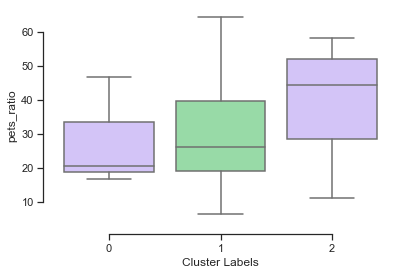

In [47]:
sns.set(style="ticks", palette="pastel")

sns.boxplot(x="Cluster Labels", y="pets_ratio",
            palette=["m", "g"],
            data=df_pets_ratio_clusters_sorted)
sns.despine(offset=10, trim=True)

This graph is quite interesting: in neighborhoods included in cluster nº2 (residential areas with parks, dog runs, etc. in the top venues positions), the pets_general ratio is higher than other clusters. If we repeat it using just the dogs_ratio:

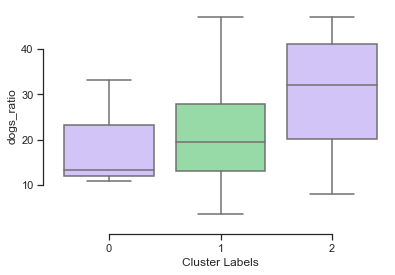

In [48]:
sns.set(style="ticks", palette="pastel")

sns.boxplot(x="Cluster Labels", y="dogs_ratio",
            palette=["m", "g"],
            data=df_pets_ratio_clusters_sorted)
sns.despine(offset=10, trim=True)

We can observe that the gap between clusters if we choose the dogs_ratio is bigger than general_pets_ratio. This is interesting because the dog's vet spending is higher than cats (according to statistics). So, the neighborhoods included in the cluster nº2 should be carefully analyzed to our business.

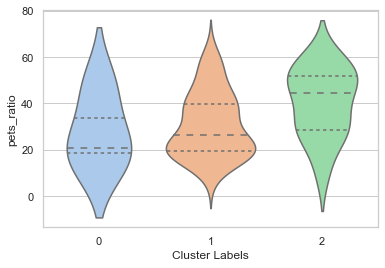

In [49]:

sns.set(style="whitegrid", palette="pastel", color_codes=True)

violinplot=sns.violinplot(x="Cluster Labels", y="pets_ratio",
               split=True, inner="quart", data=df_pets_ratio_clusters_sorted)

violinplot

### Now, we are going to include another variable to complete our analysis: our competitors (the existing vet clinics and pet stores)

First, we'll calculate the distance between the clusters' position and existing vet clinics. We are going to consider just the geographical distance (it's a simpler approach than the 'real' distance taking account transport networks but it can be a good reference too!):

For each cluster we obtain the accumulated distance respect to all clinics (in kilometers):

In [69]:
from geopy.distance import geodesic
distances=[]
for cluster in range(0,len(df_pets_ratio_clusters_sorted)):
    sum_distance=0
    
    for clinic in range(0,len(df_clinics)):
        coords_1=(df_pets_ratio_clusters_sorted.loc[cluster,'Latitude'],df_pets_ratio_clusters_sorted.loc[cluster,'Longitude'])
        coords_2=(df_clinics.loc[clinic,'Latitude'],df_clinics.loc[clinic,'Longitude'])
        distance=geodesic(coords_1, coords_2).km
        sum_distance=sum_distance+distance
    distances.append(sum_distance)
    

In [67]:
df_pets_ratio_clusters_sorted['clinic_distances']=distances
df_pets_ratio_clusters_sorted.head()


index Postal Code          Borough                 Neighborhood   Latitude  \
0     35         M4E     East Toronto                  The Beaches  43.676357   
1     78         M6R     West Toronto       Parkdale, Roncesvalles  43.648960   
2     81         M8W        Etobicoke       Alderwood, Long Branch  43.602414   
3     46         M4T  Central Toronto  Moore Park, Summerhill East  43.689574   
4     44         M4R  Central Toronto           North Toronto West  43.715383   

   Longitude Cluster Labels  Population, 2016  CAT   DOG  Total  dogs_ratio  \
0 -79.293031              1           25044.0  430  1181   1611   47.157004   
1 -79.456325              1           19857.0  417   780   1197   39.280858   
2 -79.543484              1           20674.0  400   815   1215   39.421496   
3 -79.383160              2           10463.0  114   493    607   47.118417   
4 -79.405678              1           11394.0  170   481    651   42.215201   

   cats_ratio  pets_ratio  clinic_distances  stores_distances  
0   17.169781   64.326785       1575.802177         88.544519  
1   21.000151   60.281009       1356.600515        103.272720  
2   19.347973   58.769469       1473.477817        174.565513  
3   10.895537   58.013954       1372.975338         69.243126  
4   14.920133   57.135334       1346.366334         77.570919

<Figure size 1440x720 with 0 Axes>

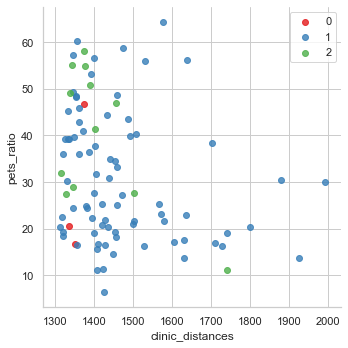

In [52]:

plt.figure(figsize=(20,10)) 

sns.lmplot( x="clinic_distances", y="pets_ratio", data=df_pets_ratio_clusters_sorted, fit_reg=False, hue='Cluster Labels', 
           palette="Set1",legend=False)
 
# Move the legend to an empty part of the plot
plt.legend(loc='upper right')
 

In the upper scatter plot we can see that highest pets_ratios are the most covered by existing vet clinics, although we can observe some remarkable exceptions (see the upper and lower right quadrant of the graph) which can be interesting placements to new clinics. On the other hand, cluster nº2 locations (which we've identified previously as potential interesting placements because of their characteristics) are well covered in most cases. 

We can repeat the same operations using the pet stores dataframe:

In [68]:
from geopy.distance import geodesic
distances2=[]
for cluster in range(0,len(df_pets_ratio_clusters_sorted)):
    sum_distance2=0
    
    for store in range(0,len(df_pet_stores)):
        coords_1=(df_pets_ratio_clusters_sorted.loc[cluster,'Latitude'],df_pets_ratio_clusters_sorted.loc[cluster,'Longitude'])
        coords_2=(df_pet_stores.loc[store,'Latitude'],df_pet_stores.loc[store,'Longitude'])
        distance2=geodesic(coords_1, coords_2).km
        sum_distance2=sum_distance2+distance2
    distances2.append(sum_distance2)
   

In [54]:
df_pets_ratio_clusters_sorted['stores_distances']=distances2

<Figure size 1440x720 with 0 Axes>

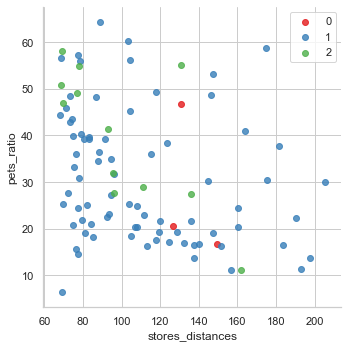

In [55]:
plt.figure(figsize=(20,10)) 

sns.lmplot( x="stores_distances", y="pets_ratio", data=df_pets_ratio_clusters_sorted, fit_reg=False, hue='Cluster Labels', 
           palette="Set1",legend=False)
 
# Move the legend to an empty part of the plot
plt.legend(loc='upper right')

Analyzing pet_stores distances respect to clusters we can reach similar conclusions as vet_clinic_distances:  highest pets_ratios clusters are the most covered by existing pet stores. On the other hand, cluster nº2 locations (which we've identified previously as potential interesting placements because of their characteristics) are well covered too. 

So, now we could set up an analytical way to identify and sort the best locations:

### A scoring approach to localize the best placements:

Using all data we can set up a procedure to localize the best placements to our new vet clinics. A possible approach consists of scoring all neighbourhoods using some of the data used in our analysis: 1) distance to existing vet clinics & pet stores and 2) Number of potential clients (using the total number of licensed pets or pets_ratios). In both cases, we'll need to standarize the parameters (we'll use a max-min approach):

In [56]:
df_scoring=df_pets_ratio_clusters_sorted
df_scoring=df_scoring.drop(['index','Borough','Population, 2016',
            'CAT','DOG','dogs_ratio','cats_ratio','pets_ratio'],axis=1)
df_scoring.head()

Postal Code                 Neighborhood   Latitude  Longitude  \
0         M4E                  The Beaches  43.676357 -79.293031   
1         M6R       Parkdale, Roncesvalles  43.648960 -79.456325   
2         M8W       Alderwood, Long Branch  43.602414 -79.543484   
3         M4T  Moore Park, Summerhill East  43.689574 -79.383160   
4         M4R           North Toronto West  43.715383 -79.405678   

  Cluster Labels  Total  clinic_distances  stores_distances  
0              1   1611       1575.802177         88.544519  
1              1   1197       1356.600515        103.272720  
2              1   1215       1473.477817        174.565513  
3              2    607       1372.975338         69.243126  
4              1    651       1346.366334         77.570919

In [57]:
min_pets=df_scoring['Total'].min()
max_pets=df_scoring['Total'].max()
df_scoring['pets_scoring']=(df_scoring['Total']-min_pets)/(max_pets-min_pets)

In [58]:
min_distance=df_scoring['clinic_distances'].min()
max_distance=df_scoring['clinic_distances'].max()
df_scoring['clinic_distances_scoring']=(df_scoring['clinic_distances']-min_distance)/(max_distance-min_distance)

In [59]:
min_distance2=df_scoring['stores_distances'].min()
max_distance2=df_scoring['stores_distances'].max()
df_scoring['stores_distances_scoring']=(df_scoring['stores_distances']-min_distance2)/(max_distance2-min_distance2)

In [60]:
df_scoring['overall_scoring']=df_scoring['pets_scoring']*df_scoring['clinic_distances_scoring']*df_scoring['stores_distances_scoring']
df_scoring=df_scoring.sort_values(by=['overall_scoring'], ascending=False)
df_scoring=df_scoring.reset_index().drop('index',axis=1)
df_scoring.head()

Postal Code                                       Neighborhood   Latitude  \
0         M1C             Highland Creek, Rouge Hill, Port Union  43.784535   
1         M1E                  Guildwood, Morningside, West Hill  43.763573   
2         M1B                                     Rouge, Malvern  43.806686   
3         M1G                                             Woburn  43.770992   
4         M1V  Agincourt North, L'Amoreaux East, Milliken, St...  43.815252   

   Longitude Cluster Labels  Total  clinic_distances  stores_distances  \
0 -79.160497              1   1072       1992.932893        205.288335   
1 -79.188711              1   1430       1879.533649        175.219760   
2 -79.194353              1    912       1927.775804        197.573899   
3 -79.216917              1    605       1801.445281        160.271611   
4 -79.284577              2    615       1741.112897        161.661890   

   pets_scoring  clinic_distances_scoring  stores_distances_scoring  \
0      0.564835                  1.000000                  1.000000   
1      0.761538                  0.833647                  0.781212   
2      0.476923                  0.904417                  0.943867   
3      0.308242                  0.719094                  0.672445   
4      0.313736                  0.630588                  0.682561   

   overall_scoring  
0         0.564835  
1         0.495956  
2         0.407125  
3         0.149051  
4         0.135037

Finally, we obtained a sorted dataframe with the best locations (M1C, M1E and M1B are the locations with the best scoring). We are going to graph the top ten neighborhoods (represented by postal codes):

In [61]:
df_scoring_top_ten=df_scoring.drop(df_scoring.index[10:])
df_scoring_top_ten=df_scoring_top_ten.drop(['Latitude','Longitude','Total','clinic_distances','stores_distances'],axis=1)
df_scoring_top_ten.head(10)

Postal Code                                       Neighborhood  \
0         M1C             Highland Creek, Rouge Hill, Port Union   
1         M1E                  Guildwood, Morningside, West Hill   
2         M1B                                     Rouge, Malvern   
3         M1G                                             Woburn   
4         M1V  Agincourt North, L'Amoreaux East, Milliken, St...   
5         M8V       Humber Bay Shores, Mimico South, New Toronto   
6         M8W                             Alderwood, Long Branch   
7         M1S                                          Agincourt   
8         M1M    Cliffcrest, Cliffside, Scarborough Village West   
9         M1K        East Birchmount Park, Ionview, Kennedy Park   

  Cluster Labels  pets_scoring  clinic_distances_scoring  \
0              1      0.564835                  1.000000   
1              1      0.761538                  0.833647   
2              1      0.476923                  0.904417   
3              1      0.308242                  0.719094   
4              2      0.313736                  0.630588   
5              1      0.991209                  0.216960   
6              1      0.643407                  0.237976   
7              1      0.313736                  0.612370   
8              1      0.457692                  0.574855   
9              1      0.584066                  0.476412   

   stores_distances_scoring  overall_scoring  
0                  1.000000         0.564835  
1                  0.781212         0.495956  
2                  0.943867         0.407125  
3                  0.672445         0.149051  
4                  0.682561         0.135037  
5                  0.569518         0.122477  
6                  0.776452         0.118887  
7                  0.609683         0.117134  
8                  0.404906         0.106533  
9                  0.317487         0.088343

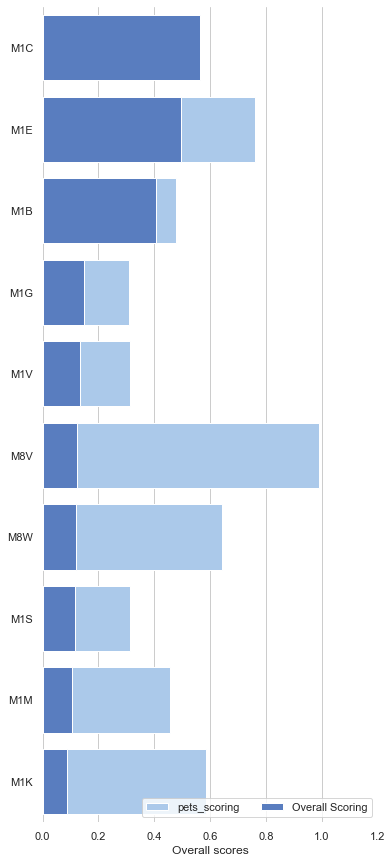

In [62]:
f, ax = plt.subplots(figsize=(6, 15))

# Plot the pet scoring (the most interesting), so we can compares the overall influence of this factor:
sns.set_color_codes("pastel")
sns.barplot(x="pets_scoring", y="Postal Code", data=df_scoring_top_ten,
            label="pets_scoring", color="b")
            
# Plot the overall scoring:
sns.set_color_codes("muted")
sns.barplot(x="overall_scoring", y="Postal Code", data=df_scoring_top_ten,
            label="Overall Scoring", color="b")



# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 1.2), ylabel="",
       xlabel="Overall scores")
sns.despine(left=True, bottom=True)

Using Folium it's a great way to visualize best locations:

In [63]:
toronto_boundaries = r'Toronto_neighborhoods.geojson' # geojson file

toronto_latitude=43.6534817
toronto_longitude=-79.3839347

#you use a zoom level of 12,
# create map and display it
toronto_map3 = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=12)

toronto_map3.choropleth(
    geo_data=toronto_boundaries,
    data=df_scoring,
    columns=['Postal Code', 'overall_scoring'],
    key_on='feature.properties.CFSAUID',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='overall scoring (best new clinics location)'
)

# display map
toronto_map3

C:\Users\roherher\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


The map shows us an interesting aspect: the best locations are concentrated in a specific area (the east of Toronto) so new clinics can cover a wider area with interesting features (high number of potential clients in a closer radius of influence).